In [18]:
import pandas as pd

In [19]:
vaccination_df = pd.read_csv('./COVID19_vaccination_doses_timeline_v202206.csv', delimiter=';')
hospitalisierung_df = pd.read_csv('./Hospitalisierung.csv', delimiter=';')
timeline_df = pd.read_csv('./CovidFaelle_Timeline.csv', delimiter=';')

In [20]:
vaccination_df = vaccination_df[['date', 'doses_administered_cumulative']]
hospitalisierung_df = hospitalisierung_df[['Meldedatum', 'IntensivBettenBelCovid19', 'NormalBettenBelCovid19']]
timeline_df = timeline_df[['Time', 'AnzahlTotTaeglich']]

In [ ]:
timeline_df['Time'] = timeline_df['Time'].str.strip('00:00:00').str.strip(' ')
timeline_df['Time'] = pd.to_datetime(timeline_df['Time'])

hospitalisierung_df['Meldedatum'] = hospitalisierung_df['Meldedatum'].str.strip('00:00:00').str.strip(' ')
hospitalisierung_df['Meldedatum'] = pd.to_datetime(hospitalisierung_df['Meldedatum'])

vaccination_df['date'] = vaccination_df['date'].str.slice(start=0, stop=10)
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])

In [22]:
timeline_df.sample(5)


,Time,AnzahlTotTaeglich
1942,2020-07-09,0
9393,2022-09-22,1
1143,2020-06-19,0
7047,2022-01-30,1
9881,2022-10-11,0


In [23]:
hospitalisierung_df.sample(5)

,Meldedatum,IntensivBettenBelCovid19,NormalBettenBelCovid19
6578,2022-12-11,20,213
4622,2022-01-05,14,231
4102,2022-10-03,29,456
2749,2021-10-25,240,903
4175,2022-03-17,25,460


In [24]:
vaccination_df.sample(5)

,date,doses_administered_cumulative
101014,2021-10-29,0
140885,2022-02-26,5117499
49781,2021-05-26,2
170510,2022-05-27,284
64476,2021-07-10,428759


In [25]:
hospitalisierung_df = hospitalisierung_df.groupby(['Meldedatum']).sum()
vaccination_df = vaccination_df.groupby(['date']).sum()
timeline_df = timeline_df.groupby(['Time']).sum()

In [26]:
timeline_df.index.names = ['date']
hospitalisierung_df.index.names = ['date']

In [27]:
timeline_df.sample(5)

,AnzahlTotTaeglich
date,
2021-07-03,46
2022-08-02,38
2021-02-23,72
2021-04-16,68
2021-11-26,158


In [28]:
hospitalisierung_df.sample(5)

,IntensivBettenBelCovid19,NormalBettenBelCovid19
date,,
2021-05-14,644,1372
2022-04-06,86,828
2022-06-05,158,1874
2021-10-30,566,2242
2022-05-13,126,1454


In [29]:
vaccination_df.sample(5)

,doses_administered_cumulative
date,
2022-06-17,37096006
2021-01-24,432144
2022-03-19,36498730
2022-08-13,37936898
2021-09-07,21466674


In [30]:
merged = pd.merge(hospitalisierung_df, timeline_df, on='date', how='outer')
merged = merged.sort_values(by=['date'])

vaccine_end_of_month = vaccination_df.groupby(['date']).sum()
vaccines_month = vaccine_end_of_month.iloc[vaccine_end_of_month.reset_index().groupby(vaccine_end_of_month.index.to_period('M'))['date'].idxmax()]

merged = pd.merge(merged, vaccines_month, on='date', how='outer')

In [31]:
month_grouped = merged.groupby([merged.index.year, merged.index.month]).sum()
month_grouped['dates'] = month_grouped.index

new_col_list = ['year', 'month']
for n, col in enumerate(new_col_list):
    month_grouped[col] = month_grouped['dates'].apply(lambda date: date[n])

month_grouped = month_grouped.drop('dates', axis=1)
month_grouped["dates"] = month_grouped["year"].astype('string') + '-' + month_grouped["month"].astype('string')

del month_grouped['year']
del month_grouped['month']

In [32]:
month_grouped = month_grouped.droplevel(0)
month_grouped = month_grouped.reset_index(drop=True)
month_grouped = month_grouped.set_index('dates')

In [33]:
month_grouped.rename(columns={'IntensivBettenBelCovid19': 'Intensive_beds'}, inplace=True)
month_grouped.rename(columns={'NormalBettenBelCovid19': 'Normal_beds'}, inplace=True)
month_grouped.rename(columns={'AnzahlTotTaeglich': 'Deaths'}, inplace=True)
month_grouped.rename(columns={'doses_administered_cumulative': 'Vaccines_cumulative'}, inplace=True)

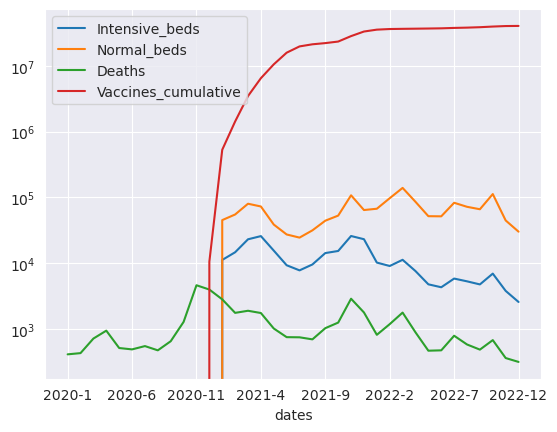

In [34]:
ax = month_grouped.plot.line(logy=True)